# Image registration using Coherent Point Drift (CPD)

Map source (user input) points to destination (ground truth) locations using `pycpd` package.

In [1]:
import json
from pathlib import Path
from typing import List, Tuple, Dict, Literal

import numpy as np
from PIL import Image, ImageDraw
from itertools import compress
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pandas as pd
from functools import partial
import optuna

from pycpd import DeformableRegistration
from pycpd import AffineRegistration

from utils.annotations import BoundingBox

c:\Users\Valenty\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read in bounding box data from intraop_document_landmarks.json

In [2]:
def label_studio_to_bboxes(path_to_json_data: Path) -> List[BoundingBox]:
    """Loads data from LabelStudio's json format into BoundingBoxes."""
    json_data: List[Dict] = json.loads(open(str(path_to_json_data)).read())
    return {
        sheet_data['data']['image'].split("-")[-1]:[
            BoundingBox(
                category=label['value']['rectanglelabels'][0],
                left=label['value']['x']/100,
                top=label['value']['y']/100,
                right=label['value']['x']/100+label['value']['width']/100,
                bottom=label['value']['y']/100+label['value']['height']/100,
            )
            for label in sheet_data['annotations'][0]['result']
        ]
        for sheet_data in json_data
    }


data_path: Path = Path("..")/"data"
# updated landmarks JSON
landmark_new: Dict[str, List[BoundingBox]] = label_studio_to_bboxes(data_path/"intraop_document_landmarks.json")

Select sheets for testing

In [10]:
src_test_bb = landmark_new['RC_0001_intraoperative.JPG']
dst_test_bb = landmark_new['unified_intraoperative_preoperative_flowsheet_v1_1_front.png']

Method to normalize values in a list - implemented due to suggestion in `pycpd` documentation

In [4]:
def flex_norm(array, lower, upper):
    '''Function takes in array to normalize along with lower and upper bounds'''
    norm_arr = []
    diff_arr = max(array) - min(array)
    min_array = min(array)
    for i in array:
    # (b-a)((x_i - min(x))/(max(x) - min(x))) + a
        norm_hold = ((upper - lower)*((i - min_array)/(diff_arr))) + lower
        norm_arr.append(norm_hold)

    return norm_arr

Method to register source image

* Extracts center coordinates from source and destination bounding box lists
* Unpacks coordinates and normalizes using `flex_norm`
* Coordinates are recombined and registered using Deformable and Affine combined registrations from `pycpd`
* Distance matrix is created with rows as (transformed) source points and columns as destination points
* Closest distance source and destination points are paired
* If `test = True` the MSE is returned, otherwise the paired indeces are returned

In [5]:
def registration(src_bb: List, dst_bb: List, alpha: float, beta: float, w: float, test=False):
    """Register points from input image to transform to destination

    Args:
        src_bb (List): Source bounding boxes
        dst_bb (List): Destination bounding boxes
        alpha (positive float): the trade-off between 
        the goodness of maximum likelihood fit and regularization
        beta (positive float): width of the Gaussian kernel
        w (float in range [0,1)): more constrained or flexible registration
        test (Bool): True to return SSE for testing, else pair list

    Returns:
        List: Tuples of paired points
        Float: (If test=True) sum of squared pair distances
    """
    src_centers = []
    for i in range(len(src_bb)):
        src_centers.append(src_bb[i].center)
    # unpack list of tuples
    src_x, src_y = zip(*src_centers)
    # NEW normalize [-1, 1]
    norm_sx = flex_norm(src_x, 0, 1)
    norm_sy = flex_norm(src_y, 0, 1)
    src_norm = list(zip(norm_sx, norm_sy))
    # convert to numpy array to fit registration specifications
    src_np = np.asarray(src_norm)

    # extract destination -- unified landmark sheet
    dst_centers = []
    for i in range(len(dst_bb)):
        dst_centers.append(dst_bb[i].center)
    # unpack list of tuples
    dst_x, dst_y = zip(*dst_centers)
    # NEW normalize to larger range for a stretch/spread effect
    norm_dx = flex_norm(dst_x, 0, 1)
    norm_dy = flex_norm(dst_y, 0, 1)
    dst_norm = list(zip(norm_dx, norm_dy))
    # convert to numpy array to fit registration specifications
    dst_np = np.asarray(dst_norm)


    # deformable registration with tuned parameters
    def_reg = DeformableRegistration(X=dst_np, Y=src_np, alpha=alpha, beta=beta, w=w)
    def_points, _ = def_reg.register()

    # affine transformation using deformable output as source points
    aff_reg = AffineRegistration(X=dst_np, Y=def_points, w=w)
    full_registration, _ = aff_reg.register()


    # create distance matrix
    euc_mat = np.array([[np.linalg.norm(i-j) for j in dst_np] for i in full_registration])
    # create index row
    mat_index = np.array(range(len(dst_np)))
    # concatenate for indexed columns matrix
    new_mat = np.vstack([mat_index, euc_mat]) # source are rows and destination are columns

    src_index = 1 # 0th row is the column indicies
    pairs = []
    distance_sum = []
    #for row in new_mat[1:]: # not including the column indices row (0)
    for row in range(1, min(len(src_np), len(dst_np))): 
        min_index = np.argmin(new_mat[1]) # choose column with minimum distance
        # pairs: (destination, source)
        # select the column index in first row, unchanged by row/column removals
        # subtract 1 to account for true index in point list
        pairs.append((int(new_mat[0][min_index]), src_index-1))
        # list of squared values for SSE metric, mat[current row][min column]
        distance_sum.append((new_mat[1][min_index])**2)
        # increment source index row counter
        src_index += 1
        # remove row and column used in pair
        new_mat = np.delete(np.delete(new_mat, 1, 0), min_index, 1)

    if test == True:
        return np.mean(distance_sum)
    else:
        return pairs

Method for checking paired point matches with classification comparison

In [6]:
def misses_test(src_bb, dst_bb, alpha, beta, w):
    """Test for the number of point pair misses based on category classification match

    Args:
        src_bb: List of source bounding boxes
        dst_bb: List of destination bounding boxes
        alpha: the trade-off between 
        the goodness of maximum likelihood fit and regularization
        beta: width of the Gaussian kernel
        w: more constrained or flexible registration

    Returns:
        misses: amount of missed pairs
    """
    # register and set inital match/miss counts
    pairs = registration(src_bb, dst_bb, alpha, beta, w)
    match = 0
    misses = 0
    miss_pairs = []
    # iterate over all paired points, identify misses
    for pair in range(len(pairs)):
        if (dst_bb[pairs[pair][0]].category == src_bb[pairs[pair][1]].category):
            match += 1
        else:
            miss_pairs.append((dst_bb[pairs[pair][0]].category, src_bb[pairs[pair][1]].category))
            misses += 1

    # display results
    print(f"Number of matches: {match} \nNumber of misses: {misses} \nMiss pairs: {miss_pairs}")
    return misses

Method to plot source and destination point comparison

In [7]:
def centers_plot(src_bb: List, dst_bb: List, fig_path):
    """Plot destination and unregistered source points

    Args:
        src_bb (List): Source bounding boxes
        dst_bb (List): Destination bounding boxes
        fig_path (str): Path for image background

    Returns:
        Image: Plotted source and destination points
    """

    csfont = {'fontname':'Century', 'fontsize': 16}
    img = np.asarray(Image.open(fig_path))

    # image scaling values
    DESIRED_IMAGE_WIDTH = img.shape[1]
    DESIRED_IMAGE_HEIGHT = img.shape[0]

    # extract centers from BB lists
    src_centers = []
    for i in range(len(src_bb)):
        src_centers.append(src_bb[i].center)

    dst_centers = []
    for i in range(len(dst_bb)):
        dst_centers.append(dst_bb[i].center)

    # unpack a list of pairs into two tuples
    src_x, src_y = zip(*src_centers)
    dst_x, dst_y = zip(*dst_centers)

    # scale to the sheet area
    sx = [value * DESIRED_IMAGE_WIDTH for value in src_x]
    sy = [value * DESIRED_IMAGE_HEIGHT for value in src_y]

    dx = [value * DESIRED_IMAGE_WIDTH for value in dst_x]
    dy = [value * DESIRED_IMAGE_HEIGHT for value in dst_y]

    font = font_manager.FontProperties(family='Century')

    plt.imshow(img)
    plt.scatter(sx, sy, s=0.7, c='red', label='Source')
    plt.scatter(dx, dy, s=0.7, c = "blue", label='Destination')
    plt.legend(loc=4, markerscale=4, prop=font) # outside: bbox_to_anchor=(1.04, 1), loc='upper left'
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    #plt.title('Bounding box center point clouds', **csfont)
    plt.savefig('BB_centers.png', dpi=1000)

    return plt.show()

Method for source, destination, and registered point comparison

In [ ]:
def reg_centers_plots(src_bb: List, dst_bb: List, alpha: float, beta: float, fig_path):
    """Register points from input image to transform to destination

    Args:
        src_bb (List): Source bounding boxes
        dst_bb (List): Destination bounding boxes
        alpha (positive float): the trade-off between 
        the goodness of maximum likelihood fit and regularization
        beta (positive float): width of the Gaussian kernel
        fig_path (str): Path for image background

    Returns:
        List: Tuples of paired points
        Float: (If test=True) sum of squared pair distances
    """
    # image scaling values
    img = np.asarray(Image.open(fig_path))
    DESIRED_IMAGE_WIDTH = img.shape[1]
    DESIRED_IMAGE_HEIGHT = img.shape[0]

    # extract source -- input sheet
    src_centers = []
    for i in range(len(src_bb)):
        src_centers.append(src_bb[i].center)
    # convert to numpy array to fit registration specifications
    src_np = np.asarray(src_centers)

    # extract destination -- unified landmark sheet
    dst_centers = []
    for i in range(len(dst_bb)):
        dst_centers.append(dst_bb[i].center)
    # convert to numpy array to fit registration specifications
    dst_np = np.asarray(dst_centers)


    # deformable registration with tuned parameters
    def_reg = DeformableRegistration(X=dst_np, Y=src_np, alpha=alpha, beta=beta, w=0)
    def_points, _ = def_reg.register() 

    # affine transformation using deformable output as source points
    aff_reg = AffineRegistration(X=dst_np, Y=def_points, w=0)
    full_registration, _ = aff_reg.register()

    # unpack a list of pairs into two tuples
    src_x, src_y = zip(*src_centers)
    dst_x, dst_y = zip(*dst_centers)
    reg_x, reg_y = zip(*full_registration)


    # scale to the sheet area
    sx = [value * DESIRED_IMAGE_WIDTH for value in src_x]
    sy = [value * DESIRED_IMAGE_HEIGHT for value in src_y]

    dx = [value * DESIRED_IMAGE_WIDTH for value in dst_x]
    dy = [value * DESIRED_IMAGE_HEIGHT for value in dst_y]

    rx = [value * DESIRED_IMAGE_WIDTH for value in reg_x]
    ry = [value * DESIRED_IMAGE_HEIGHT for value in reg_y]

    csfont = {'fontname':'Century', 'fontsize': 16}
    font = font_manager.FontProperties(family='Century')
    plt.imshow(img)

    plt.scatter(dx, dy, s=0.7, c = "blue", label='Destination')
    plt.scatter(sx, sy, s=0.7, c='red', label='Source') 
    plt.scatter(rx, ry, s=0.7, c = "green", label='Registered')
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    #plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.legend(loc=4, markerscale=4, prop=font)
    plt.savefig('BB_registered.png', dpi=1000)

    return plt.show()

-------------------

## Demonstrating methods
Paths useful for plot backgrounds

In [11]:
rc1 = '../data/chart_images/RC_0001_intraoperative.JPG'
blank = 'blank.png'
unified = '../data/unified_intraoperative_preoperative_flowsheet_v1_1_front.png'

Point comparison plot

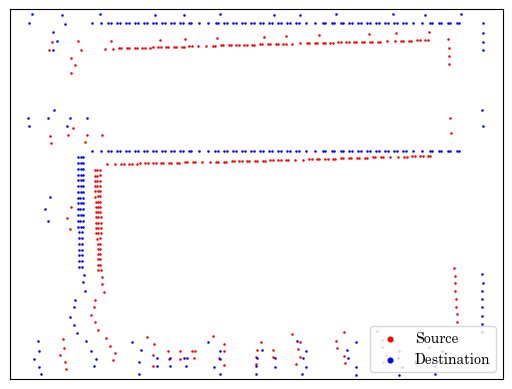

In [14]:
centers_plot(src_test_bb, dst_test_bb, blank)

Registered plot comparison

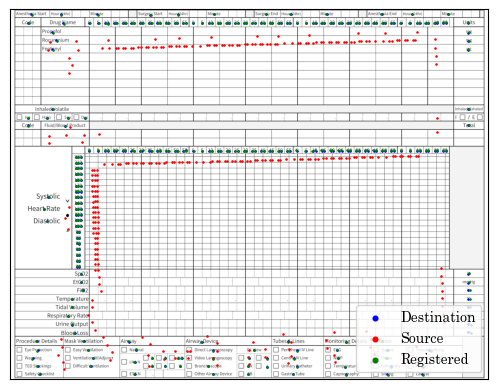

In [15]:
reg_centers_plots(src_test_bb, dst_test_bb, 5.5, 5.5, unified)

-----------------------

## Optuna optimization
Block to tune registration hyperparameters using `optuna`

In [ ]:
# initalize a list of optimal alphas and betas
optimal_ab = []

# optuna it!
def objective(trial, src_bb, dst_bb):
    a = trial.suggest_float('a', 0.0001, 10)
    b = trial.suggest_float('b', 1, 50)
    return registration(src_bb, dst_bb, a, b, 0, test=True)

# iterate through all source sheets
for s in range(1, 21):
    src_test_bb = landmark_new[f'RC_00{str(s).zfill(2)}_intraoperative.JPG']
    dst_test_bb = landmark_new['unified_intraoperative_preoperative_flowsheet_v1_1_front.png']

    study = optuna.create_study()
    objective = partial(objective, src_bb = src_test_bb, dst_bb = dst_test_bb)
    study.optimize(objective, n_trials = 100)

    # append best values
    optimal_ab.append(study.best_params)

Results from tuning - no convergence for alpha or beta

| Alpha     | Beta       |
|-----------|------------|
| 9.555487 | 15.839255 |
| 8.689428 | 3.137179  |
| 9.885223 | 7.525192  |
| 4.633045 | 4.994629  |
| 3.288892 | 4.982841  |
| 8.219519 | 6.324293  |
| 7.123864 | 3.827184  |
| 9.947020 | 15.812725 |
| 6.202528 | 8.057993  |
| 6.198658 | 4.019745  |
| 2.323800 | 6.100392  |
| 8.289052 | 3.286750  |
| 9.998079 | 21.986754 |
| 3.640954 | 5.119107  |
| 9.537355 | 11.067843 |
| 9.975795 | 7.542868  |
| 2.532360 | 6.040393  |
| 2.424120 | 10.574781 |
| 4.961687 | 2.917743  |
| 3.604495 | 5.028179  |

Plot alpha and beta optimal parameters

In [8]:
all_20 = [
[9.555487,	15.839255],
[8.689428,	3.137179],
[9.885223,	7.525192],
[4.633045,	4.994629],
[3.288892,	4.982841],
[8.219519,	6.324293],
[7.123864,	3.827184],
[9.947020,	15.812725],
[6.202528,	8.057993],
[6.198658,	4.019745],
[2.323800,	6.100392],
[8.289052,	3.286750],
[9.998079,	21.986754],
[3.640954,	5.119107],
[9.537355,	11.067843],
[9.975795,	7.542868],
[2.532360,	6.040393],
[2.424120,	10.574781],
[4.961687,	2.917743],
[3.604495,	5.028179]]

df_20 = pd.DataFrame(all_20, columns=['a','b'])

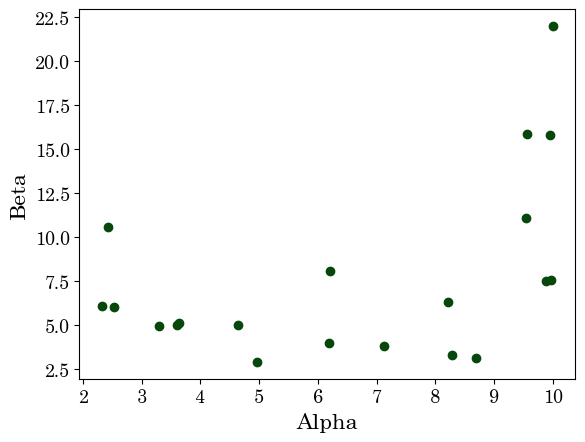

In [ ]:
csfont = {'fontname':'Century', 'fontsize': 16}

plt.scatter(x=df_20['a'], y=df_20['b'], c = 'xkcd:forest green')
plt.xlabel('Alpha', **csfont)
plt.ylabel('Beta', **csfont)
plt.tick_params(axis='both', labelsize = 13, labelfontfamily = "Century")
#plt.savefig('optuna_ab.png')